### Sean's Idea: use piha analyzer latent space vectors (embeddings) in LanceDB to do knowledge discovery on piha data

In [18]:
# imports
import os, sys

# Get the absolute path of the directory containing your modules
module_dir = os.path.abspath('pyha-analyzer-2.0/')

# Add the directory to the system path
sys.path.append(module_dir)

from pyha_analyzer import PyhaTrainer, PyhaTrainingArguments, extractors
from pyha_analyzer.models.demo_CNN import ResnetConfig, ResnetModel
from pyha_analyzer.preprocessors import MelSpectrogramPreprocessors
from pyha_analyzer.models import EfficentNet

import torch
import numpy as np

In [3]:
coralreef_extractor = extractors.CoralReef()
coral_ads = coralreef_extractor("/home/a.jajodia.229/acoustic/local_data/coral")

Casting the dataset:   0%|          | 0/26694 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3432 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/8009 [00:00<?, ? examples/s]

In [4]:
preprocessor = MelSpectrogramPreprocessors(duration=5, class_list=coral_ads["train"].features["labels"].feature.names)

coral_ads["train"].set_transform(preprocessor)
coral_ads["valid"].set_transform(preprocessor)
coral_ads["test"].set_transform(preprocessor)

resnet50d_config = ResnetConfig(
    num_classes=2, itorchut_channels=1, problem_type = "multi_label_classification", output_hidden_states = True
)

#model = EfficentNet(num_classes=len(coral_ads["train"].features["labels"].names))
model = EfficentNet(num_classes=2)
model.load_state_dict(torch.load('/home/a.jajodia.229/acoustic/acoustic_knowledge_discovery/pyha-analyzer-2.0/coral_model_4146a1f.pt'))



<All keys matched successfully>

In [5]:
data = coral_ads['test'][0:100]

In [6]:
def normalize(v):
    min, _ = torch.min(v, dim = 1)
    max, _ = torch.max(v, dim = 1)
    
    
    min = min.reshape((len(v), 1))
    max = max.reshape((len(v), 1))
    
    return (v - min)/(max- min)

In [49]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

embeddings = model.get_embedding(**data).double()

embeddings = torch.tensor(pca.fit_transform(embeddings))

In [50]:
embeddings

tensor([[ 1.9247e+01, -2.3301e+00],
        [ 3.1862e+01,  7.8127e+00],
        [-1.1050e+01,  2.8325e-01],
        [ 2.3948e+01,  4.2620e-01],
        [-1.0527e+01, -4.0479e-01],
        [-1.0992e+01,  4.6506e-01],
        [-1.1632e+01,  8.7079e-01],
        [-1.1500e+01,  7.5930e-01],
        [ 2.3941e+01,  9.1553e-01],
        [ 1.4960e+01, -5.1375e+00],
        [-1.0722e+01, -1.8360e-01],
        [-1.1178e+01,  3.1067e-01],
        [-1.0755e+01, -8.8142e-02],
        [ 2.8320e-01, -9.0255e+00],
        [-1.1482e+01,  7.8538e-01],
        [ 1.9930e+01, -2.5670e+00],
        [-1.1922e+01,  1.1668e+00],
        [ 2.0026e+01, -2.3468e+00],
        [-1.1201e+01,  3.3839e-01],
        [-1.1168e+01,  4.1057e-01],
        [ 1.7739e+01, -3.0801e+00],
        [-1.1334e+01,  4.5940e-01],
        [ 2.5501e+01,  1.6246e+00],
        [-1.0630e+01, -1.9771e-01],
        [ 2.7293e+01,  3.8726e+00],
        [-1.1115e+01,  2.7774e-01],
        [ 2.6937e+01,  2.8928e+00],
        [ 1.8793e+01, -3.428

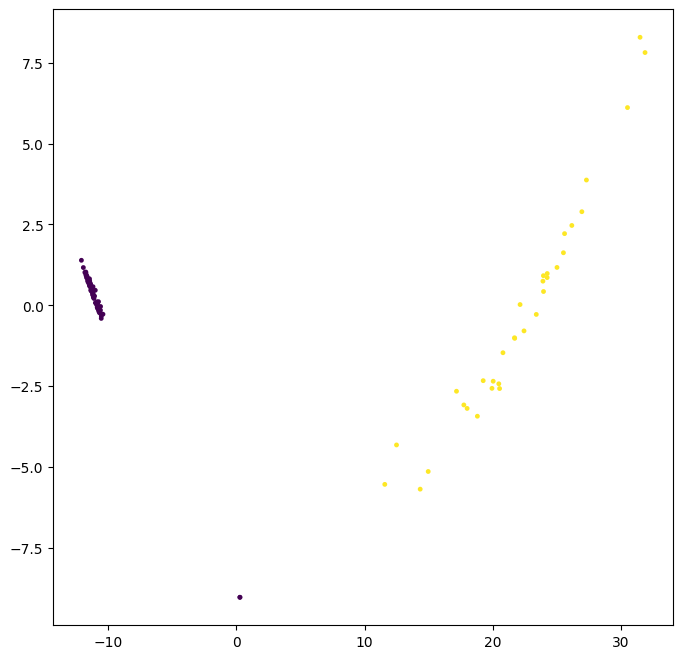

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 8))

plt.scatter(embeddings[:,0], embeddings[:,1], c=data['labels'][:,1], edgecolors='none', marker='o', s=12)

In [8]:
def MAD(p, y):
    """
    Calculates marginal adequacy degree (MAD) matrix from feature vector and cluster values
    """
    a = torch.pow(p, y)
    b = torch.pow((1-p),(1-y))
    
    return a.mul(b)

def GAD(p, y):
    """
    Calculates global adequacy degree (GAD) matrix from marginal adequacy
    """
    M = MAD(p, y)
    num = torch.prod(M, dim = 1).reshape((len(M), 1))
    den = torch.prod(M, dim = 1).reshape((len(M), 1)) + torch.prod(1-M, dim = 1).reshape((len(M), 1))
    
    return torch.nan_to_num(num/den)

In [33]:
embeddings.shape

torch.Size([100, 5])

In [41]:
# implement lamda
Nf = len(embeddings[0])

p = torch.zeros(Nf)

num_embeddings = len(embeddings)

nc = [1,0]

iterations = 1

for i in range(iterations):
    for f in range(num_embeddings):
        
        
        y = embeddings[f]

        if f == 0 and i == 0:
            p[0:] = 0.5
            new_p = (y + p)/2
            p = torch.vstack((p, new_p))
            
            continue
        
        
        g = GAD(p, y)
        
        print(g)
        
        best_similarity, best_cluster = torch.max(g, dim = 0)
        
        print(best_similarity, best_cluster)
        
        if best_cluster == 0:
            new_p = (y + p[0,:])/2
            p = torch.vstack((p, new_p))
            nc[0] += 1
            nc.append(0)
            
            continue
        else:
            old_p = p[best_cluster, :]
            p[best_cluster] = old_p + ((y - old_p)/nc[best_cluster])
            nc[best_cluster] += 1  
        
    
    

tensor([[0.5000],
        [0.9788]], dtype=torch.float64)
tensor([0.9788], dtype=torch.float64) tensor([1])
tensor([[0.5000],
        [0.0000]], dtype=torch.float64)
tensor([0.5000], dtype=torch.float64) tensor([0])
tensor([[0.5000],
        [0.0000],
        [0.0068]], dtype=torch.float64)
tensor([0.5000], dtype=torch.float64) tensor([0])
tensor([[0.5000],
        [0.0000],
        [0.9902],
        [0.0089]], dtype=torch.float64)
tensor([0.9902], dtype=torch.float64) tensor([2])
tensor([[0.5000],
        [0.0000],
        [0.0000],
        [0.0084]], dtype=torch.float64)
tensor([0.5000], dtype=torch.float64) tensor([0])
tensor([[0.5000],
        [0.0000],
        [0.0000],
        [0.0096],
        [0.9876]], dtype=torch.float64)
tensor([0.9876], dtype=torch.float64) tensor([4])
tensor([[0.5000],
        [0.0000],
        [0.0000],
        [0.0092],
        [0.0000]], dtype=torch.float64)
tensor([0.5000], dtype=torch.float64) tensor([0])
tensor([[0.5000],
        [0.0000],
        [0